# Solve the inventory management problem using Python/Numba.

John Stachurski
Sun 13 Aug 2023 04:25:41

In [1]:
from model import *
from dp_algos import *
from plot_code import *

In [2]:
f = njit(f) # use numba to JIT-compile f

# Operators and functions 

In [3]:
@njit
def B(y, i_z, a, v, model):
    """
    B(y, a, v) = r(y, a) + β(z) Σ_{y′, z′} v(y′, z′) R(y, a, y′) Q(z, z′)

    """
    K, c, κ, p = model.params
    r, R, y_vals, z_vals, Q = model.arrays
    β = z_vals[i_z]
    cv = 0.0
    for i_zp in range(len(z_vals)):
        for yp in y_vals:
            cv += v[yp, i_zp] * R[y, a, yp] * Q[i_z, i_zp]
    return r[y, a] + β * cv

In [4]:
@njit
def T(v, model):
    "The Bellman operator."
    K, c, κ, p = model.params
    r, R, y_vals, z_vals, Q = model.arrays
    n_y, n_z = model.sizes
    new_v = np.empty_like(v)
    for i_z in range(n_z):
        for y in y_vals:
            Γy = range(K - y + 1)
            B_vals = [B(y, i_z, a, v, model) for a in Γy]
            new_v[y, i_z] = max(B_vals)
    return new_v

In [5]:
@njit
def T_σ(v, σ, model):
    "The policy operator."
    K, c, κ, p = model.params
    r, R, y_vals, z_vals, Q = model.arrays
    n_y, n_z = model.sizes
    new_v = np.empty_like(v)
    for i_z in range(n_z):
        for y in y_vals:
            new_v[y, i_z] = B(y, i_z, σ[y, i_z], v, model) 
    return new_v

In [6]:
@njit
def get_greedy(v, model):
    "Get a v-greedy policy.  Returns indices of choices."
    K, c, κ, p = model.params
    r, R, y_vals, z_vals, Q = model.arrays
    n_y, n_z = model.sizes
    σ_star = np.zeros((len(y_vals), n_z), dtype=int32)
    for i_z in range(n_z):
        for y in y_vals:
            max_val = -np.inf
            for a in range(K - y + 1):
                current_val = B(y, i_z, a, v, model)
                if current_val > max_val:
                    maximizer = a
                    max_val = current_val
            σ_star[y, i_z] = maximizer
    return σ_star

In [7]:
@njit
def get_value(σ, model):
    "Get the value v_σ of policy σ."
    K, c, κ, p = model.params
    r, R, y_vals, z_vals, Q = model.arrays
    n_y, n_z = model.sizes
    n = n_z * n_y
    # Build L_σ and r_σ as multi-index arrays
    L_σ = np.zeros((n_y, n_z, n_y, n_z))
    r_σ = np.zeros((n_y, n_z))
    for y in y_vals:
        for i_z in range(n_z):
            a = σ[y, i_z]
            β = z_vals[i_z]
            r_σ[y, i_z] = r[y, a]
            for yp in y_vals:
                for i_zp in range(n_z):
                    L_σ[y, i_z, yp, i_zp] = β * R[y, a, yp] * Q[i_z, i_zp]
    # Reshape for matrix algebra
    L_σ = np.reshape(L_σ, (n, n))
    r_σ = np.reshape(r_σ, n)
    # Apply matrix operations --- solve for the value of σ 
    I = np.identity(n)
    v_σ = np.linalg.solve(I - L_σ,  r_σ)
    # Return as multi-index array
    return np.reshape(v_σ, (n_y, n_z))

# Custom solvers 

In [8]:
def solve_model_numba(model, algorithm="OPI", **kwargs):
    """
    General purpose solver. 

    algorithm : OPI, VFI or HPI

    """

    # Set up
    n_y, n_z = model.sizes
    v_init = np.zeros((n_y, n_z))

    # Solve
    print(f"Solving model using {algorithm}.")
    match algorithm:
        case "OPI":
            solver = optimistic_policy_iteration
            args = (v_init, 
                lambda v, σ: T_σ(v, σ, model), 
                lambda v: get_greedy(v, model))
        case "HPI":
            solver = howard_policy_iteration
            args = (v_init, 
                lambda σ: get_value(σ, model), 
                lambda v: get_greedy(v, model))
        case "VFI":
            solver = value_function_iteration
            args = (v_init, 
                lambda v: T(v, model), 
                lambda v: get_greedy(v, model))
        case _:
            raise ValueError("Algorithm must be in {OPI, VFI, HPI}")

    qe.tic()
    v_star, σ_star = solver(*args, **kwargs)
    run_time = qe.toc()
    print(f"Solved model using {algorithm} in {run_time:.5f} seconds.")

    return v_star, σ_star

In [9]:
def test_timing_numba(model,
                      m_vals=range(1, 100, 20),
                      figname="numba_timing.pdf",
                      savefig=False):
    """
    Plot relative timing of different algorithms.

    """

    qe.tic()
    _, σ_pi = solve_model_numba(model, algorithm="HPI")
    hpi_time = qe.toc()

    qe.tic()
    _, σ_vfi = solve_model_numba(model, algorithm="VFI")
    vfi_time = qe.toc()

    error = np.max(np.abs(σ_vfi - σ_pi))
    if error:
        print("Warning: VFI policy deviated with max error {error}.")

    opi_times = []
    for m in m_vals:
        qe.tic()
        _, σ_opi = solve_model_numba(model, algorithm="OPI", m=m)
        opi_times.append(qe.toc())

        error = np.max(np.abs(σ_opi - σ_pi))
        if error:
            print("Warning: OPI policy deviated with max error {error}.")

    plot_timing(hpi_time, 
                vfi_time,
                opi_times,
                m_vals, 
                figname=figname,
                savefig=False)

    return hpi_time, vfi_time, opi_times

# Simulations and plots 

In [10]:
model = create_sdd_inventory_model()

Building model with ρ(L) = 0.9751716609507842


## Solve by VFI

In [11]:
v_star, σ_star = solve_model_numba(model, algorithm="VFI")

Solving model using VFI.


Completed iteration 25 with error 0.5612918187425802.


Completed iteration 50 with error 0.37760311527087964.


Completed iteration 75 with error 0.22781271574230288.


Completed iteration 100 with error 0.12966912474841052.


Completed iteration 125 with error 0.06841133244553532.


Completed iteration 150 with error 0.03108826968598777.


Completed iteration 175 with error 0.014717604780919658.


Completed iteration 200 with error 0.007728671529960707.


Completed iteration 225 with error 0.0041302272069572155.


Completed iteration 250 with error 0.002206459813073991.


Completed iteration 275 with error 0.0011779116780843424.


Completed iteration 300 with error 0.0006285733275888106.


Completed iteration 325 with error 0.0003353535262320406.


Completed iteration 350 with error 0.00017889424245964847.


Completed iteration 375 with error 9.542456400879473e-05.


Completed iteration 400 with error 5.089879924469187e-05.


Completed iteration 425 with error 2.7148494247342114e-05.


Completed iteration 450 with error 1.448034407758314e-05.


Completed iteration 475 with error 7.723411918902912e-06.


Completed iteration 500 with error 4.119437804206427e-06.


Completed iteration 525 with error 2.197181004248705e-06.


Completed iteration 550 with error 1.1719072361415783e-06.


Terminated successfully in 558 iterations.


TOC: Elapsed: 0:02:51.94
Solved model using VFI in 171.94109 seconds.


## Solve by HPI

In [12]:
v_star, σ_star = solve_model_numba(model, algorithm="HPI")

Solving model using HPI.


Concluded loop 1 with error 66.
Concluded loop 2 with error 60.


Concluded loop 3 with error 32.


Concluded loop 4 with error 32.
Concluded loop 5 with error 24.


Concluded loop 6 with error 24.
Concluded loop 7 with error 24.


Concluded loop 8 with error 0.
TOC: Elapsed: 0:00:5.61
Solved model using HPI in 5.61342 seconds.


## Solve by OPI

In [13]:
v_star, σ_star = solve_model_numba(model, algorithm="OPI")

Solving model using OPI.


Completed iteration 10 with error 0.00398914428492958.


TOC: Elapsed: 0:00:11.34
Solved model using OPI in 11.34851 seconds.


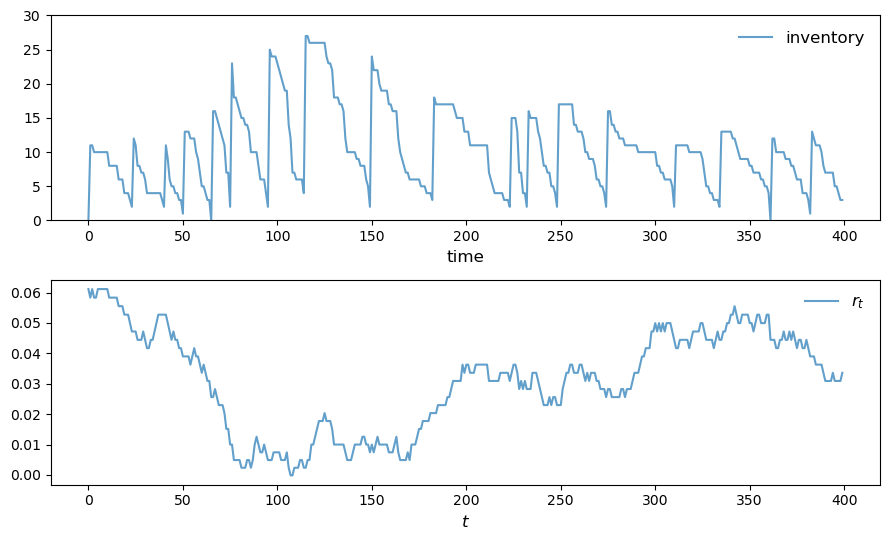

In [14]:
plot_ts(model, σ_star, figname="numba_ts.pdf", savefig=False)

## Test timing

Solving model using HPI.
Concluded loop 1 with error 66.


Concluded loop 2 with error 60.
Concluded loop 3 with error 32.
Concluded loop 4 with error 32.
Concluded loop 5 with error 24.


Concluded loop 6 with error 24.


Concluded loop 7 with error 24.
Concluded loop 8 with error 0.
TOC: Elapsed: 0:00:3.98
Solved model using HPI in 3.98552 seconds.
TOC: Elapsed: 0:00:3.98
Solving model using VFI.


Completed iteration 25 with error 0.5612918187425802.


Completed iteration 50 with error 0.37760311527087964.


Completed iteration 75 with error 0.22781271574230288.


Completed iteration 100 with error 0.12966912474841052.


Completed iteration 125 with error 0.06841133244553532.


Completed iteration 150 with error 0.03108826968598777.


Completed iteration 175 with error 0.014717604780919658.


Completed iteration 200 with error 0.007728671529960707.


Completed iteration 225 with error 0.0041302272069572155.


Completed iteration 250 with error 0.002206459813073991.


Completed iteration 275 with error 0.0011779116780843424.


Completed iteration 300 with error 0.0006285733275888106.


Completed iteration 325 with error 0.0003353535262320406.


Completed iteration 350 with error 0.00017889424245964847.


Completed iteration 375 with error 9.542456400879473e-05.


Completed iteration 400 with error 5.089879924469187e-05.


Completed iteration 425 with error 2.7148494247342114e-05.


Completed iteration 450 with error 1.448034407758314e-05.


Completed iteration 475 with error 7.723411918902912e-06.


Completed iteration 500 with error 4.119437804206427e-06.


Completed iteration 525 with error 2.197181004248705e-06.


Completed iteration 550 with error 1.1719072361415783e-06.


Terminated successfully in 558 iterations.
TOC: Elapsed: 0:02:51.10
Solved model using VFI in 171.10542 seconds.
TOC: Elapsed: 0:02:51.10
Solving model using OPI.


Completed iteration 10 with error 0.6480358762326093.


Completed iteration 20 with error 0.5949305169605843.


Completed iteration 30 with error 0.5251459484602243.


Completed iteration 40 with error 0.4502411260545287.


Completed iteration 50 with error 0.37760311527087964.


Completed iteration 60 with error 0.311392522632449.


Completed iteration 70 with error 0.25348563920215383.


Completed iteration 80 with error 0.20428999885411514.


Completed iteration 90 with error 0.1633451023325918.


Completed iteration 100 with error 0.12966912474841052.


Completed iteration 110 with error 0.10191243757392243.


Completed iteration 120 with error 0.07865530805723608.


Completed iteration 130 with error 0.05904856720101037.


Completed iteration 140 with error 0.04311205522372319.


Completed iteration 150 with error 0.03108826968598777.


Completed iteration 160 with error 0.022647420777808236.


Completed iteration 170 with error 0.01689273636190336.


Completed iteration 180 with error 0.01287975724367385.


Completed iteration 190 with error 0.009949277899593767.


Completed iteration 200 with error 0.007728671529960707.


Completed iteration 210 with error 0.0060141729953926415.


Completed iteration 220 with error 0.004681465137338137.


Completed iteration 230 with error 0.003643763932657862.


Completed iteration 240 with error 0.0028356519919228163.


Completed iteration 250 with error 0.002206459813073991.


Completed iteration 260 with error 0.0017166848875262986.


Completed iteration 270 with error 0.0013355082948720565.


Completed iteration 280 with error 0.001038896093632502.


Completed iteration 290 with error 0.0008081157057162613.


Completed iteration 300 with error 0.0006285733275888106.


Completed iteration 310 with error 0.0004889036860262763.


Completed iteration 320 with error 0.0003802583785912361.


Completed iteration 330 with error 0.0002957500884122055.


Completed iteration 340 with error 0.00023001891723595236.


Completed iteration 350 with error 0.00017889424245964847.


Completed iteration 360 with error 0.0001391312026015612.


Completed iteration 370 with error 0.00010820542954803614.


Completed iteration 380 with error 8.415320764498802e-05.


Completed iteration 390 with error 6.544703997946044e-05.


Completed iteration 400 with error 5.089879924469187e-05.


Completed iteration 410 with error 3.958436084161576e-05.


Completed iteration 420 with error 3.0784961055019266e-05.


Completed iteration 430 with error 2.3941573402908034e-05.


Completed iteration 440 with error 1.861941635183939e-05.


Completed iteration 450 with error 1.448034407758314e-05.


Completed iteration 460 with error 1.1261370822523986e-05.


Completed iteration 470 with error 8.757966703853981e-06.


Completed iteration 480 with error 6.81106531885689e-06.


Completed iteration 490 with error 5.296958661915596e-06.


Completed iteration 500 with error 4.119437804206427e-06.


Completed iteration 510 with error 3.2036803787605095e-06.


Completed iteration 520 with error 2.491496637446744e-06.


Completed iteration 530 with error 1.9376322057951256e-06.


Completed iteration 540 with error 1.506892658653669e-06.


Completed iteration 550 with error 1.1719072361415783e-06.


TOC: Elapsed: 0:02:50.19
Solved model using OPI in 170.19201 seconds.
TOC: Elapsed: 0:02:50.19
Solving model using OPI.


Completed iteration 10 with error 0.23575181290821234.


Completed iteration 20 with error 0.0012292555287132245.


Completed iteration 30 with error 6.262373972276691e-06.


TOC: Elapsed: 0:00:14.90
Solved model using OPI in 14.90267 seconds.
TOC: Elapsed: 0:00:14.90
Solving model using OPI.


Completed iteration 10 with error 0.02117210695655558.


Completed iteration 20 with error 6.989141212443428e-07.
TOC: Elapsed: 0:00:11.37
Solved model using OPI in 11.37527 seconds.
TOC: Elapsed: 0:00:11.37
Solving model using OPI.


Completed iteration 10 with error 0.0029193267479570295.


TOC: Elapsed: 0:00:11.14
Solved model using OPI in 11.14543 seconds.
TOC: Elapsed: 0:00:11.14
Solving model using OPI.


Completed iteration 10 with error 0.0003544690333612266.


TOC: Elapsed: 0:00:10.74
Solved model using OPI in 10.74998 seconds.
TOC: Elapsed: 0:00:10.75


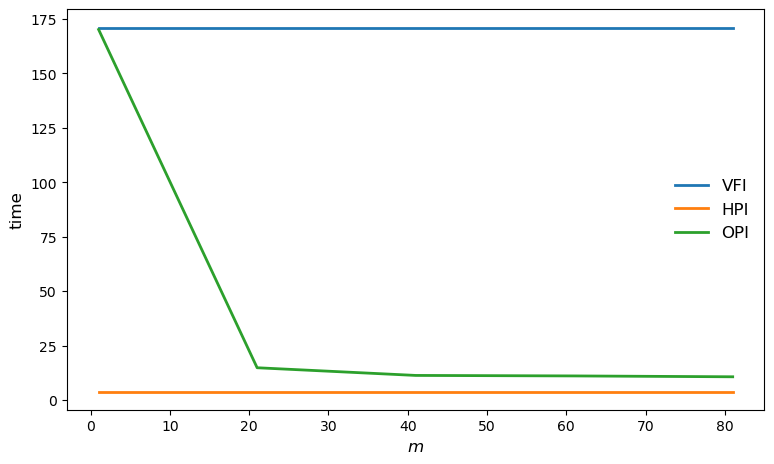

In [15]:
hpi_time, vfi_time, opi_times = test_timing_numba(model)